The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 注意力提示
:label:`sec_attention-cues`

谢谢你关注这本书。注意力是一种稀缺的资源：目前你正在阅读这本书而忽略了其余的书。因此，与金钱类似，你的注意力是用机会成本来支付的。为了确保您现在的关注投入值得，我们非常积极地关注我们的注意力，以制作一本好书。注意力是生命拱门的基石，也是任何作品例外主义的关键。

由于经济学研究稀缺资源的分配，因此我们正处在关注经济时代，人类的注意力被视为可以交换的有限、有价值和稀缺的商品。为了利用它，已经开发了许多商业模式。在音乐或视频流媒体服务上，我们要么关注他们的广告，要么付钱来隐藏它们。为了在线游戏世界的增长，我们要么注意参与战斗，以吸引新玩家，要么付钱立即变得强大。没什么是免费的。

总而言之，关注的是，我们环境中的信息并不稀少。在检查视觉场景时，我们的视神经收到的信息大约为每秒 $10^8$ 位，远远超过了我们的大脑能够完全处理的水平。幸运的是，我们的祖先从经验中学到（也称为数据），**并非所有的感官输入都是一样的**。在整个人类历史中，只将注意力引向感兴趣的一小部分信息的能力使我们的大脑能够更明智地分配资源来生存、成长和社交，例如检测掠食者、捕食者和伴侣。

## 生物学中的注意力提示

为了解释我们的注意力是如何在视觉世界中部署的，一个二组件（two-component）的框架已经出现并普遍存在。这个想法可以追溯到 19 世纪 90 年代的威廉·詹姆斯，他被认为是 “美国心理学之父” :cite:`James.2007`。在这个框架中，受试者使用 **非自主提示** 和 **自主提示** 有选择地引导注意力的焦点。

非自主性提示是基于环境中物体的显著性和显眼性。想象一下，你面前有五个物品：一份报纸、一篇研究论文、一杯咖啡、一本笔记本和一本 :numref:`fig_eye-coffee` 中的书。虽然所有纸制品都是黑白印刷的，但咖啡杯是红色的。换句话说，这种咖啡在这种视觉环境中本质上是突出和显眼的，自动而且非自愿地引起人们的注意。所以你把 fovea（视力最高的黄斑中心）带到咖啡上，如 :numref:`fig_eye-coffee` 所示。

![Using the nonvolitional cue based on saliency (red cup, non-paper), attention is involuntarily directed to the coffee.](../img/eye-coffee.svg)
:width:`400px`
:label:`fig_eye-coffee`

喝咖啡后，你会变得兴奋并想读书。所以你转过头，重新聚焦你的眼睛，然后看看 :numref:`fig_eye-book` 中描述的书。与 :numref:`fig_eye-coffee` 中的咖啡偏向于根据显著程度进行选择的情况不同，在这种依赖任务的情况下，您可以选择受认知和言语控制的书。使用基于变量选择标准的自主提示，这种形式的注意力更为谨慎。该主题的自愿努力也更加强大。

![Using the volitional cue (want to read a book) that is task-dependent, attention is directed to the book under volitional control.](../img/eye-book.svg)
:width:`400px`
:label:`fig_eye-book`

## 查询、键和值

受到解释注意力部署的非自主和自主的注意提示的启发，我们将在下文中描述通过纳入这两个注意力提示来设计注意机制的框架。

首先，考虑只有非自主提示可用的更简单的情况。要将选择偏向于感官输入，我们可以简单地使用参数化的全连接层，甚至是非参数化的最大值池化或平均值池化。

因此，将注意力机制与那些全连接的层或池层区别开来的是包含了自主提示。在注意机制的背景下，我们将自主提示称为 **查询**（Queries）。给定任何查询，注意机制通过 **注意力池化**（attention pooling） 偏向于感官输入（sensory inputs）（例如中间特征表示）的选择。在注意机制的背景下，这些感官输入被称为 **值**（Values）。更一般地说，每个值都与一个 **键**（Keys） 配对，这可以想象为该感官输入的非自主提示。如 :numref:`fig_qkv` 所示，我们可以设计注意力池，以便给定的查询（自主提示）可以与键（非自主提示）进行交互，这将指导偏差选择对值（感官输入）的偏差选择。

![Attention mechanisms bias selection over values (sensory inputs) via attention pooling, which incorporates queries (volitional cues) and keys (nonvolitional cues).](http://d2l.ai/_images/qkv.svg)
:label:`fig_qkv`

请注意，注意力机制的设计有许多替代方案。例如，我们可以设计一个不可区分的注意力模型，该模型可以使用强化学习方法 :cite:`Mnih.Heess.Graves.ea.2014` 进行训练。鉴于该框架在 :numref:`fig_qkv` 中占据主导地位，该框架下的模型将成为本章我们关注的中心。

## 注意力的可视化

平均池化可以被视为输入的加权平均值，其中权重是均匀分布的。实际上，注意力池化使用加权平均值聚合值，其中权重是在给定查询和不同键之间计算的。


In [1]:
import torch
from d2l import torch as d2l

为了可视化注意力权重，我们定义了 `show_heatmaps` 函数。它的输入 `matrices` 具有形状（要显示的行数，要显示的列数，查询数，键数）。


In [2]:
#@save
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

为了进行演示，我们考虑一个简单的情况，即仅当查询和键相同时，注意力权重为 1；否则为零。


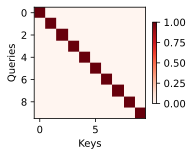

In [3]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

在接下来的章节中，我们经常调用此函数来显示注意力权重。

## 摘要

* 人类的注意力是有限、宝贵和稀缺的资源。
* 受试者使用非自主和自主提示有选择地专注注意力。前者基于显著程度，后者取决于任务。
* 由于包含了自主提示，注意机制与全连接的层或池层不同。
* 注意机制通过注意力池化使选择偏向于值（感官输入），其中包含查询（言论提示）和键（非自主提示）。键和值是配对的。
* 我们可以直观地可视化查询和键之间的注意力权重。

## 练习

1. 在机器翻译中通过令牌解码序列令牌时，自主提示可能是什么？什么是非自主的提示和感官输入？
1. 随机生成 $10 \times 10$ 矩阵并使用 `softmax` 运算来确保每行都是有效的概率分布。可视化输出注意力权重。


[Discussions](https://discuss.d2l.ai/t/1592)
